# Data Assimilation

## Sensitivity analysis

In [60]:
#!pip install SALib

In [61]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import readHistData as hist

In [62]:
# Definir limites fixos de temperatura
TMIN, TMAX = 0, 40

# Calcular os valores mínimos e máximos de temperatura nos primeiros 690 dias (para referência)
days = [0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510,540,570,600,630,660,690]

temp_values = [hist.temperature(day) for day in days]
TEMP_MIN_OBSERVED = np.min(temp_values)
TEMP_MAX_OBSERVED = np.max(temp_values)

print(f'Temperatura mínima observada: {TEMP_MIN_OBSERVED:.2f}°C')
print(f'Temperatura máxima observada: {TEMP_MAX_OBSERVED:.2f}°C')
print(f'Limites fixos utilizados: TMIN={TMIN}, TMAX={TMAX}')
print('ok')

Temperatura mínima observada: 24.55°C
Temperatura máxima observada: 29.01°C
Limites fixos utilizados: TMIN=0, TMAX=40
ok


In [63]:
equations = []
days = [0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510,540,570,600,630,660,690]
mu10 = 0.1170
mu20 = 0.025
mu30 = 0.01 
gamma0 = 0.5596
r0 = 34
#0,1390625
k0 = 89000 #k0 * area do quadrado (800m*800m)
e0 = 0.24

def func(x):
    # Apenas os parâmetros independentes: Tmin e fraction para cada parâmetro
    Tminmu1, fraction_mu1, Tmin2, fraction_2, Tmin3, fraction_3, Tmingamma, fraction_gamma, Tminr, fraction_r, Tmink, fraction_k, Tminee, fraction_e = x
    
    # Calcular Tmax a partir de Tmin e fraction
    Tmaxmu1 = Tminmu1 + fraction_mu1 * (TMAX - Tminmu1)
    Tmax2 = Tmin2 + fraction_2 * (TMAX - Tmin2)
    Tmax3 = Tmin3 + fraction_3 * (TMAX - Tmin3)
    Tmaxgamma = Tmingamma + fraction_gamma * (TMAX - Tmingamma)
    Tmaxr = Tminr + fraction_r * (TMAX - Tminr)
    Tmaxk = Tmink + fraction_k * (TMAX - Tmink)
    Tmaxe = Tminee + fraction_e * (TMAX - Tminee)
    
    equationsADT = []
    equationsOVT = []
    for t in range(24):
        T = hist.temperature(days[t])
        P = hist.pluviosity(days[t])

        # Converter Tmin e Tmax para M e D usando as novas variáveis
        Mmu1 = (Tminmu1 + Tmaxmu1) / 2
        Dmu1 = abs((Tmaxmu1 - Tminmu1)) / 2
        Mmu2 = (Tmin2 + Tmax2) / 2
        Dmu2 = abs((Tmax2 - Tmin2)) / 2
        Mmu3 = (Tmin3 + Tmax3) / 2
        Dmu3 = abs((Tmax3 - Tmin3)) / 2
        Mgamma = (Tmingamma + Tmaxgamma) / 2
        Dgamma = abs((Tmaxgamma - Tmingamma)) / 2
        Mr = (Tminr + Tmaxr) / 2
        Dr = abs((Tmaxr - Tminr)) / 2
        Mk = (Tmink + Tmaxk) / 2
        Dk = abs((Tmaxk - Tmink)) / 2
        Me = (Tminee + Tmaxe) / 2
        De = abs((Tmaxe - Tminee)) / 2

        mu1 = (2 - hist.plateau(Dmu1,Mmu1,T))*mu10
        mu2 = (2 - hist.plateau(Dmu2,Mmu2,T))*mu20
        mu3 = (2 - hist.plateau(Dmu3, Mmu3, T)) * mu30 # NOVO: Cálculo de mu3 
        gamma = hist.normal(Dgamma,Mgamma,T)*gamma0
        r = hist.phi(10,40,P)*hist.normal(Dr,Mr,T)*r0
        k = hist.phi(10,40,P)*hist.normal(Dk,Mk,T)*k0
        e = e0*hist.normal(De,Me,T)* hist.phi(10,40,P)
        
        # ATUALIZADO: Nova fórmula para Q0 
        # Evita divisão por zero se algum termo no denominador for zero
        denominator_q0 = mu1 * (mu2 + gamma) * (mu3 + e)
        if denominator_q0 == 0:
            Q0 = 0
        else:
            Q0 = (gamma * e * r) / denominator_q0

        if Q0 > 1:
            # eqADT (F*) usa a mesma estrutura, mas o valor de Q0 mudou
            eqADT = k * (gamma / mu1) * (1 - 1 / Q0)
            
            # ATUALIZADO: Nova fórmula para eqOVT (E*) 
            # Evita divisão por zero
            denominator_eqOVT = mu1 * (mu3 + e)
            if denominator_eqOVT == 0:
                eqOVT = 0
            else:
                eqOVT = k * (gamma * r) / denominator_eqOVT * (1 - 1 / Q0)
        else:
            eqADT = 0
            eqOVT = 0
            
        equationsADT.append(eqADT)
        equationsOVT.append(eqOVT)
   
    return np.mean(eqADT) + np.mean(eqOVT)

In [64]:
# Definir o problema (priors) usando apenas os parâmetros independentes: Tmin e fraction
problem = {
    'num_vars': 14,  # 7 parâmetros × 2 (Tmin e fraction)
    'names': ['Tminmu1', 'fraction_mu1', 'Tmin2', 'fraction_2', 'Tmin3', 'fraction_3', 
              'Tmingamma', 'fraction_gamma', 'Tminr', 'fraction_r', 'Tmink', 'fraction_k', 
              'Tminee', 'fraction_e'],
    'bounds': [
        [TMIN, TMAX], [0.001, 1.0],  # mu1: Tmin, fraction
        [TMIN, TMAX], [0.001, 1.0],  # mu2: Tmin, fraction
        [TMIN, TMAX], [0.001, 1.0],  # mu3: Tmin, fraction
        [TMIN, TMAX], [0.001, 1.0],  # gamma: Tmin, fraction
        [TMIN, TMAX], [0.001, 1.0],  # r: Tmin, fraction
        [TMIN, TMAX], [0.001, 1.0],  # k: Tmin, fraction
        [TMIN, TMAX], [0.001, 1.0],   # e: Tmin, fraction
    ]
}
# Gerar amostras
n = 14   #19
param_values = saltelli.sample(problem, 2**n)

/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_63135/1357557615.py:19: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2**n)


In [65]:
from tqdm import tqdm
# Y = np.array([func(x) for x in tqdm(param_values, desc="Calculando")])



In [66]:
import pickle
import numpy as np

# # Salvar Y em arquivo pickle com novo nome
# with open('Y_sobol_results_NewParams.pkl', 'wb') as f:
#     pickle.dump(Y, f)

# print(f"Variável Y salva com sucesso! Shape: {Y.shape}")
# print(f"Tamanho do arquivo: {len(Y)} amostras")

# Para carregar posteriormente (código de exemplo):
with open('Y_sobol_results_NewParams.pkl', 'rb') as f:
    Y = pickle.load(f)

In [67]:
# Analisar a sensibilidade
sobol_results = sobol.analyze(problem, Y, print_to_console=True)

                      ST   ST_conf
Tminmu1         0.153726  0.114328
fraction_mu1    0.117139  0.060049
Tmin2           0.000036  0.000037
fraction_2      0.000060  0.000071
Tmin3           0.106785  0.058602
fraction_3      0.067156  0.062175
Tmingamma       1.071151  0.578851
fraction_gamma  0.549123  0.208292
Tminr           0.764528  0.249377
fraction_r      0.733874  0.706880
Tmink           0.542534  0.179507
fraction_k      0.466881  0.233373
Tminee          0.509788  0.207509
fraction_e      0.336241  0.167384
                      S1   S1_conf
Tminmu1         0.000113  0.001197
fraction_mu1   -0.001926  0.003502
Tmin2           0.000010  0.000022
fraction_2     -0.000070  0.000145
Tmin3           0.000494  0.000573
fraction_3     -0.000344  0.000473
Tmingamma       0.004089  0.006763
fraction_gamma  0.003460  0.005812
Tminr           0.006164  0.014123
fraction_r      0.000251  0.009507
Tmink           0.004674  0.004864
fraction_k      0.003180  0.008684
Tminee         -0.00

In [68]:
print(sobol_results)

{'S1': array([ 1.13449685e-04, -1.92599020e-03,  9.65354690e-06, -6.99946956e-05,
        4.94399894e-04, -3.44081049e-04,  4.08879318e-03,  3.46021712e-03,
        6.16390420e-03,  2.50833606e-04,  4.67443238e-03,  3.18043987e-03,
       -4.23520863e-04,  8.23817450e-04]), 'S1_conf': array([1.19701066e-03, 3.50195852e-03, 2.22115941e-05, 1.45066892e-04,
       5.72654916e-04, 4.72693646e-04, 6.76277128e-03, 5.81152920e-03,
       1.41234382e-02, 9.50737272e-03, 4.86422070e-03, 8.68400266e-03,
       2.47911245e-03, 3.38586478e-03]), 'ST': array([1.53725625e-01, 1.17139039e-01, 3.56042842e-05, 6.02929390e-05,
       1.06785349e-01, 6.71557575e-02, 1.07115076e+00, 5.49123451e-01,
       7.64528417e-01, 7.33873718e-01, 5.42533644e-01, 4.66880531e-01,
       5.09787547e-01, 3.36241407e-01]), 'ST_conf': array([1.14328447e-01, 6.00492037e-02, 3.73057376e-05, 7.09761958e-05,
       5.86022845e-02, 6.21748849e-02, 5.78851302e-01, 2.08292075e-01,
       2.49377363e-01, 7.06880168e-01, 1.795071

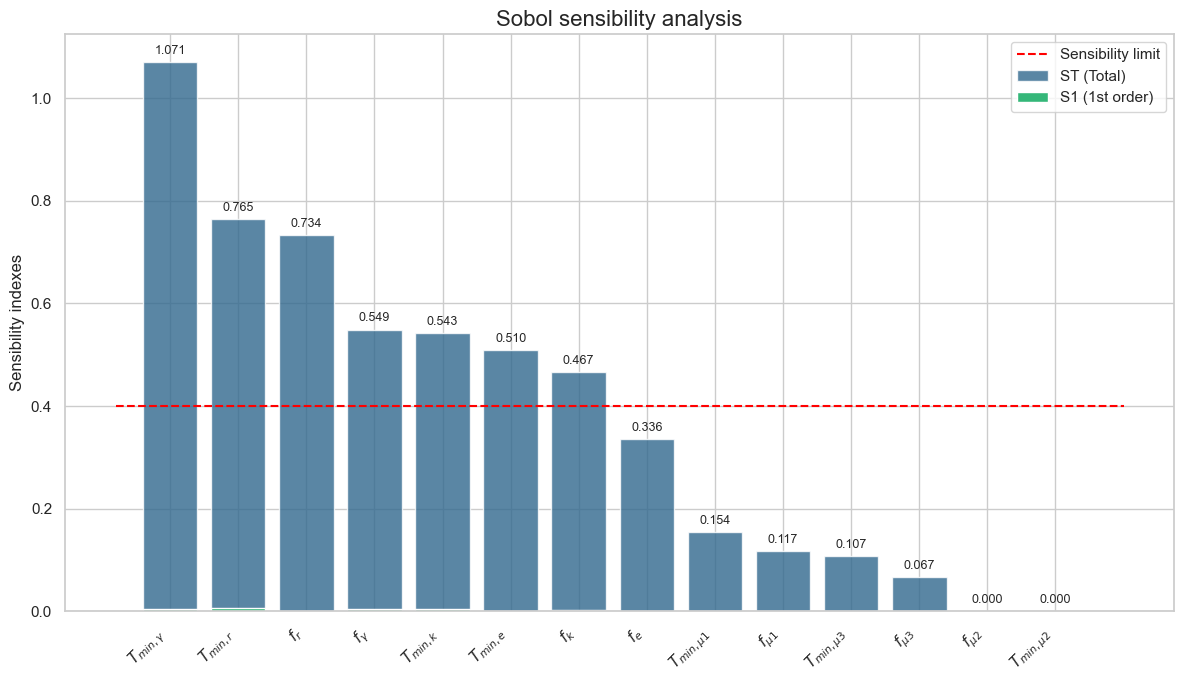

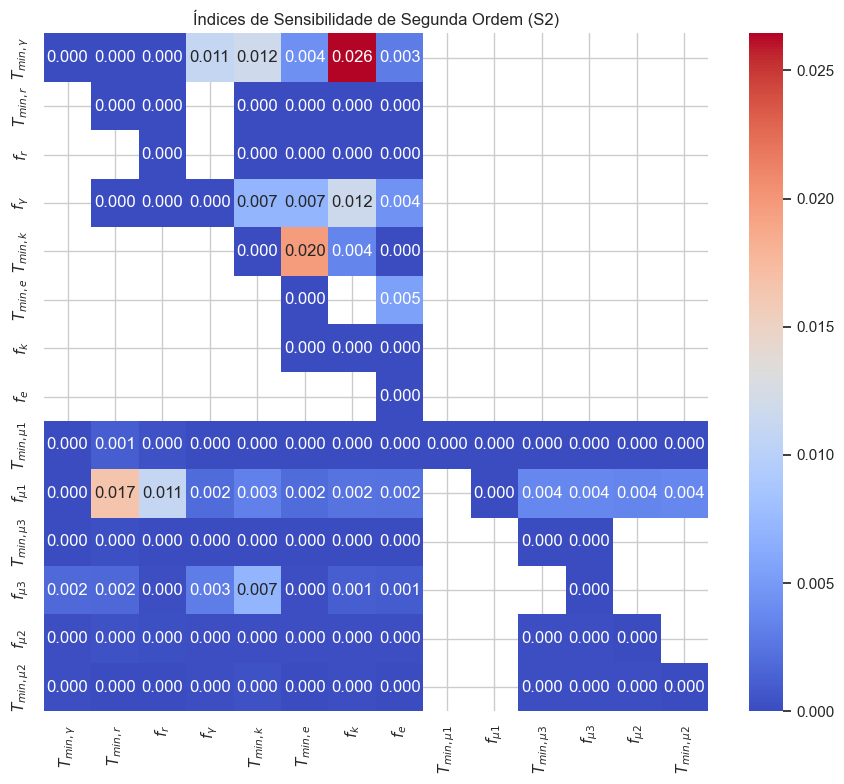

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_sobol_results(sobol_results, parameter_names):
    """
    Plota os índices de Sobol de forma otimizada usando seaborn.
    aa
    - Converte valores negativos para 0.
    - Plota S1 sobre ST em um único gráfico ordenado por relevância.
    - Mantém o heatmap para os índices S2.
    
    :param sobol_results: Dicionário com os índices de Sobol gerado pelo SALib.
    :param parameter_names: Lista de nomes dos parâmetros.
    """
    # Ativa o tema do seaborn para um visual mais atraente
    sns.set_theme(style="whitegrid", palette="viridis")
    
    num_params = len(parameter_names)
    
    # --- Gráfico de Barras Combinado para S1 e ST ---
    fig, ax = plt.subplots(figsize=(12, 7))

    # Converte valores negativos para 0, pois são artefatos numéricos
    s1_indices = np.maximum(0, sobol_results['S1'])
    st_indices = np.maximum(0, sobol_results['ST'])

    # Ordena os parâmetros pelo índice ST (do maior para o menor) para focar nos mais influentes
    sorted_indices = np.argsort(st_indices)[::-1]
    sorted_st = st_indices[sorted_indices]
    sorted_s1 = s1_indices[sorted_indices]
    sorted_names = [parameter_names[i] for i in sorted_indices]
    
    x = np.arange(num_params)
    width = 0.8  # Largura das barras

    # Plota as barras de ST (Índice Total)
    ax.bar(x, sorted_st, width, label='ST (Total)', color=sns.color_palette("viridis", 2)[0], alpha=0.8)
    
    # Plota as barras de S1 (Índice de 1ª Ordem) por cima das de ST
    ax.bar(x, sorted_s1, width, label='S1 (1st order)', color=sns.color_palette("viridis", 2)[1])

    # Adiciona uma linha de limite para identificar parâmetros sensíveis (comumente 0.01)
    ax.hlines(0.4, -width, num_params, linestyles='--', color='red', label='Sensibility limit')

    # Adiciona os valores de ST acima das barras
    for i, val in enumerate(sorted_st):
        ax.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    # Melhora a estética do gráfico
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_names, rotation=45, ha="right")
    ax.set_ylabel("Sensibility indexes")
    ax.set_title("Sobol sensibility analysis", fontsize=16)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # --- Matriz de Calor para os Índices de Segunda Ordem S2 ---
    s2_indices = np.maximum(0, sobol_results['S2'])
    
    # Cria a matriz S2 e a ordena para consistência com o gráfico de barras
    S2_matrix = np.zeros((num_params, num_params))
    for i in range(num_params):
        for j in range(num_params):
            S2_matrix[i, j] = s2_indices[i, j] if i != j else 0
            
    sorted_S2_matrix = S2_matrix[sorted_indices, :][:, sorted_indices]
    
    plt.figure(figsize=(9, 8))
    sns.heatmap(
        sorted_S2_matrix, 
        xticklabels=sorted_names, 
        yticklabels=sorted_names, 
        cmap='coolwarm', 
        annot=True,  # Adiciona os valores numericos
        fmt=".3f"    # Formato dos valores
    )
    plt.title("Índices de Sensibilidade de Segunda Ordem (S2)")
    plt.tight_layout()
    plt.show()

# Plotar com os nomes corretos dos parâmetros independentes (Tmin e fraction)
plot_sobol_results(
    sobol_results, 
    [
        r'$T_{min,\mu1}$', r'$f_{\mu1}$', 
        r'$T_{min,\mu2}$', r'$f_{\mu2}$', 
        r'$T_{min,\mu3}$', r'$f_{\mu3}$', 
        r'$T_{min,\gamma}$', r'$f_{\gamma}$', 
        r'$T_{min,r}$', r'$f_{r}$', 
        r'$T_{min,k}$', r'$f_{k}$', 
        r'$T_{min,e}$', r'$f_{e}$'
    ]
)

# Fitting parks, streets and houses separately

In [70]:
import pandas as pd
data = pd.read_csv('dataNew.csv')

In [71]:
data.head(10)

,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity
0,0,5.857706,0.000000,0.614281,0.000000,0.042207,0.160572,25.828571,0.0
1,1,4.856361,21.520516,47.521355,0.000000,0.000000,0.057177,26.300000,78.9
2,2,12.854108,32.466210,59.432528,0.038002,0.000279,0.000000,26.700000,0.0
3,3,0.000000,36.921104,96.546907,0.026983,0.031282,0.000000,28.016667,0.0
4,4,0.000000,22.665511,78.618613,0.000000,0.039708,0.101667,27.328571,20.5
5,5,0.000000,77.276956,141.725590,0.019477,0.029886,0.025627,26.883333,81.2
6,6,2.505161,43.368230,86.111253,0.021219,0.000247,0.000000,26.283333,0.0
7,7,0.000000,24.020041,24.011788,0.034991,0.014083,0.001033,25.071429,0.0
8,8,0.000000,32.786299,80.381163,0.025081,0.067984,0.000000,24.280000,0.0
9,9,9.579923,20.073535,0.000000,0.000000,0.131544,0.133791,24.400000,0.0


In [72]:
park = np.concatenate((data['OVT_park'].to_numpy(),data['ADT_park'].to_numpy()))
street = np.concatenate((data['OVT_street'].to_numpy(),data['ADT_street'].to_numpy()))
house = np.concatenate((data['OVT_house'].to_numpy(),data['ADT_house'].to_numpy()))

In [73]:
import numpy as np
import lmfit


def func(params):
    Tminmu1 = params["Tminmu1"].value
    Tmaxmu1 = params["Tmaxmu1"].value
    Tmin2 = params["Tmin2"].value
    Tmax2 = params["Tmax2"].value
    Tmin3 = params["Tmin3"].value
    Tmax3 = params["Tmax3"].value
    Tmingamma = params["Tmingamma"].value
    Tmaxgamma = params["Tmaxgamma"].value
    Tminr = params["Tminr"].value
    Tmaxr = params["Tmaxr"].value
    Tmink = params["Tmink"].value
    Tmaxk = params["Tmaxk"].value
    Tminee = params["Tminee"].value
    Tmaxe = params["Tmaxe"].value
    
    mu10 = 0.1170
    mu20 = 0.025
    mu30 = 0.01
    gamma0 = 0.5596
    r0 = 34
    k0 = 89000
    e0 = 0.24
    
    equationsADT = []
    equationsOVT = []
    for t in range(24):
        T = hist.temperature(days[t])
        P = hist.pluviosity(days[t])

        # Converter Tmin e Tmax para M e D usando as novas fórmulas
        Mmu1 = (Tminmu1 + Tmaxmu1) / 2
        Dmu1 = abs((Tmaxmu1 - Tminmu1)) / 2
        Mmu2 = (Tmin2 + Tmax2) / 2
        Dmu2 = abs((Tmax2 - Tmin2)) / 2
        Mmu3 = (Tmin3 + Tmax3) / 2
        Dmu3 = abs((Tmax3 - Tmin3)) / 2
        Mgamma = (Tmingamma + Tmaxgamma) / 2
        Dgamma = abs((Tmaxgamma - Tmingamma)) / 2
        Mr = (Tminr + Tmaxr) / 2
        Dr = abs((Tmaxr - Tminr)) / 2
        Mk = (Tmink + Tmaxk) / 2
        Dk = abs((Tmaxk - Tmink)) / 2
        Me = (Tminee + Tmaxe) / 2
        De = abs((Tmaxe - Tminee)) / 2

        mu1 = (2 - hist.plateau(Dmu1,Mmu1,T))*mu10
        mu2 = (2 - hist.plateau(Dmu2,Mmu2,T))*mu20
        mu3 = (2 - hist.plateau(Dmu3, Mmu3, T)) * mu30 # NOVO: Cálculo de mu3 
        gamma = hist.normal(Dgamma,Mgamma,T)*gamma0
        r = hist.phi(10,40,P)*hist.normal(Dr,Mr,T)*r0
        k = hist.phi(10,40,P)*hist.normal(Dk,Mk,T)*k0
        e = e0*hist.normal(De,Me,T)* hist.phi(10,40,P)
        
        # ATUALIZADO: Nova fórmula para Q0 
        # Evita divisão por zero se algum termo no denominador for zero
        denominator_q0 = mu1 * (mu2 + gamma) * (mu3 + e)
        if denominator_q0 == 0:
            Q0 = 0
        else:
            Q0 = (gamma * e * r) / denominator_q0

        if Q0 > 1:
            # eqADT (F*) usa a mesma estrutura, mas o valor de Q0 mudou
            eqADT = k * (gamma / mu1) * (1 - 1 / Q0)
            
            # ATUALIZADO: Nova fórmula para eqOVT (E*) 
            # Evita divisão por zero
            denominator_eqOVT = mu1 * (mu3 + e)
            if denominator_eqOVT == 0:
                eqOVT = 0
            else:
                eqOVT = k * (gamma * r) / denominator_eqOVT * (1 - 1 / Q0)
        else:
            eqADT = 0
            eqOVT = 0
            
        equationsADT.append(eqADT)
        equationsOVT.append(eqOVT)
    return np.concatenate((equationsOVT,equationsADT))

# To account for the different magnitudes in the two segments (0-23 and 24+), 
# you can normalize or weight the residuals for each segment separately.
# One common approach is to divide each segment's residuals by the standard deviation or mean of the corresponding observed data.

def errorPark(params):
    predicted = func(params)
    # Split observed and predicted into OVT (0:24) and ADT (24:)
    ovt_obs = park[:24]
    adt_obs = park[24:]
    ovt_pred = predicted[:24]
    adt_pred = predicted[24:]
    # Calculate standard deviations (add small value to avoid division by zero)
    ovt_std = np.std(ovt_obs) + 1e-8
    adt_std = np.std(adt_obs) + 1e-8
    # Normalize residuals
    ovt_resid = (ovt_obs - ovt_pred) / ovt_std
    adt_resid = (adt_obs - adt_pred) / adt_std
    
    return np.concatenate((ovt_resid, adt_resid))

def errorStreet(params):
    predicted = func(params)
    # Split observed and predicted into OVT (0:24) and ADT (24:)
    ovt_obs = street[:24]
    adt_obs = street[24:]
    ovt_pred = predicted[:24]
    adt_pred = predicted[24:]
    # Calculate standard deviations (add small value to avoid division by zero)
    ovt_std = np.std(ovt_obs) + 1e-8
    adt_std = np.std(adt_obs) + 1e-8
    # Normalize residuals
    ovt_resid = (ovt_obs - ovt_pred) / ovt_std
    adt_resid = (adt_obs - adt_pred) / adt_std
    return np.concatenate((ovt_resid, adt_resid))

def errorHouse(params):
    predicted = func(params)
    # Split observed and predicted into OVT (0:24) and ADT (24:)
    ovt_obs = house[:24]
    adt_obs = house[24:]
    ovt_pred = predicted[:24]
    adt_pred = predicted[24:]
    # Calculate standard deviations (add small value to avoid division by zero)
    ovt_std = np.std(ovt_obs) + 1e-8
    adt_std = np.std(adt_obs) + 1e-8
    # Normalize residuals
    ovt_resid = (ovt_obs - ovt_pred) / ovt_std
    adt_resid = (adt_obs - adt_pred) / adt_std
    return np.concatenate((ovt_resid, adt_resid))


# Criar parâmetros LMFit usando os novos parâmetros com frações
params2 = lmfit.Parameters()

params2.add("Tminmu1", value=(TMIN+TMAX)/2, min=TMIN, max=TMAX)
params2.add("fraction_mu1", value=0.5, min=0.1, max=1.0)
params2.add("Tmaxmu1", expr=f"Tminmu1 + fraction_mu1 * ({TMAX} - Tminmu1)")

params2.add("Tmin2", value=(TMIN+TMAX)/2, min=TMIN, max=TMAX)
params2.add("fraction_2", value=0.5, min=0.1, max=1.0)
params2.add("Tmax2", expr=f"Tmin2 + fraction_2 * ({TMAX} - Tmin2)")

params2.add("Tmin3", value=25, min=TMIN, max=TMAX)
params2.add("fraction_3", value=0.5, min=0.1, max=1.0)
params2.add("Tmax3", expr=f"Tmin3 + fraction_3 * ({TMAX} - Tmin3)")

params2.add("Tmingamma", value=25, min=TMIN, max=TMAX)
params2.add("fraction_gamma", value=0.5, min=0.1, max=1.0)
params2.add("Tmaxgamma", expr=f"Tmingamma + fraction_gamma * ({TMAX} - Tmingamma)")

params2.add("Tminr", value=25, min=TMIN, max=TMAX)
params2.add("fraction_r", value=0.5, min=0.1, max=1.0)
params2.add("Tmaxr", expr=f"Tminr + fraction_r * ({TMAX} - Tminr)")

params2.add("Tmink", value=25, min=TMIN, max=TMAX)
params2.add("fraction_k", value=0.5, min=0.1, max=1.0)
params2.add("Tmaxk", expr=f"Tmink + fraction_k * ({TMAX} - Tmink)")

params2.add("Tminee", value=25, min=TMIN, max=TMAX)
params2.add("fraction_e", value=0.5, min=0.1, max=1.0)
params2.add("Tmaxe", expr=f"Tminee + fraction_e * ({TMAX} - Tminee)")

In [74]:
nonSensible= []
sensible = []

# Mapear os índices do Sobol para os nomes dos parâmetros corretos (apenas Tmin e fraction)
sobol_param_names = ['Tminmu1', 'fraction_mu1', 'Tmin2', 'fraction_2', 'Tmin3', 'fraction_3', 
                    'Tmingamma', 'fraction_gamma', 'Tminr', 'fraction_r', 'Tmink', 'fraction_k', 
                    'Tminee', 'fraction_e']

for i, param_name in enumerate(sobol_param_names):
    if param_name in params2:  # Verificar se o parâmetro existe em params2
        if sobol_results["ST"][i] < 0.4:
            nonSensible.append(param_name)
        else:
            sensible.append(param_name)

print("Non sensible:",nonSensible)
print("Sensible:",sensible)

# Fixar todos os parâmetros que não são sensíveis
for param in nonSensible:
    if param in params2:
        params2[param].vary = False

Non sensible: ['Tminmu1', 'fraction_mu1', 'Tmin2', 'fraction_2', 'Tmin3', 'fraction_3', 'fraction_e']
Sensible: ['Tmingamma', 'fraction_gamma', 'Tminr', 'fraction_r', 'Tmink', 'fraction_k', 'Tminee']


In [75]:
params2

name,value,initial value,min,max,vary,expression
Tminmu1,20.0000000,20.0,0.00000000,40.0000000,False,
fraction_mu1,0.50000000,0.5,0.10000000,1.00000000,False,
Tmaxmu1,30.0000000,None,-inf,inf,False,Tminmu1 + fraction_mu1 * (40 - Tminmu1)
Tmin2,20.0000000,20.0,0.00000000,40.0000000,False,
fraction_2,0.50000000,0.5,0.10000000,1.00000000,False,
Tmax2,30.0000000,None,-inf,inf,False,Tmin2 + fraction_2 * (40 - Tmin2)
Tmin3,25.0000000,25,0.00000000,40.0000000,False,
fraction_3,0.50000000,0.5,0.10000000,1.00000000,False,
Tmax3,32.5000000,None,-inf,inf,False,Tmin3 + fraction_3 * (40 - Tmin3)
Tmingamma,25.0000000,25,0.00000000,40.0000000,True,


In [76]:
import matplotlib.pyplot as plt

# Defina estilos globais para todos os gráficos matplotlib
plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 26,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'lines.linewidth': 5,
    'axes.linewidth': 2      # Espessura das bordas dos eixos
})

### Fitting park

In [78]:
best_result = None
best_chisqr = np.inf

for i in range(10):
    print(f"Run {i+1}/10")
    # Global optimization (differential_evolution)
    result_global = lmfit.minimize(
        errorPark,
        params2,
        method="differential_evolution",
        maxiter=2000,
        popsize=30,
        seed=i,  # Use a different seed for each run
        polish=True,
        tol=1e-8,
    )

    # Local optimization (leastsq) using the result from global optimization
    resultAll = lmfit.minimize(
        errorPark,
        result_global.params,
        method="leastsq"
    )

    print(f"Run {i+1} chi-squared: {resultAll.chisqr}")
    if resultAll.chisqr < best_chisqr:
        best_chisqr = resultAll.chisqr
        best_result = resultAll

print("Best fit report:")
print(lmfit.fit_report(best_result))
resultAll = best_result
parkResult = best_result

Run 1/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 1 chi-squared: 46.73415196377695
Run 2/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 2 chi-squared: 73.18933406802708
Run 3/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 3 chi-squared: 91.42556320119715
Run 4/10
Run 4 chi-squared: 46.665302093815214
Run 5/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 5 chi-squared: 44.89854121318076
Run 6/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 6 chi-squared: 79.6590022293687
Run 7/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 7 chi-squared: 91.42556320119715
Run 8/10
Run 8 chi-squared: 46.66530286231891
Run 9/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 9 chi-squared: 91.42556320119715
Run 10/10
Run 10 chi-squared: 91.42556320119715
Best fit report:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3046
    # data points      = 48
    # variables        = 7
    chi-square         = 44.8985412
    reduced chi-square = 1.09508637
    Akaike info crit   = 10.7938061
    Bayesian info crit = 23.8922132
[[Variables]]
    Tminmu1:         20 (fixed)
    fraction_mu1:    0.5 (fixed)
    Tmaxmu1:         30.0000000 +/- 0.00000000 (0.00%) == 'Tminmu1 + fraction_mu1 * (40 - Tminmu1)'
    Tmin2:           20 (fixed)
    fraction_2:      0.5 (fixed)
    Tmax2:           30.0000000 +/- 0.00000000 (0.00%) == 'Tmin2 + fraction_2 * (40 - Tmin2)'
    Tmin3:           25 (fixed)
    fraction_3:      0.5 (fixed)
    Tmax3:           32.5000000 +/- 0.00000000 (0.00%) == 'Tmin3 + fraction_3 * (40 - Tmin3)'
    Tmingamma:       29.8752046 +/- 8.59554908 (28.77%) (init = 21.5174)
    fraction_gamma:  1.00000000 +/- 17890.3768 

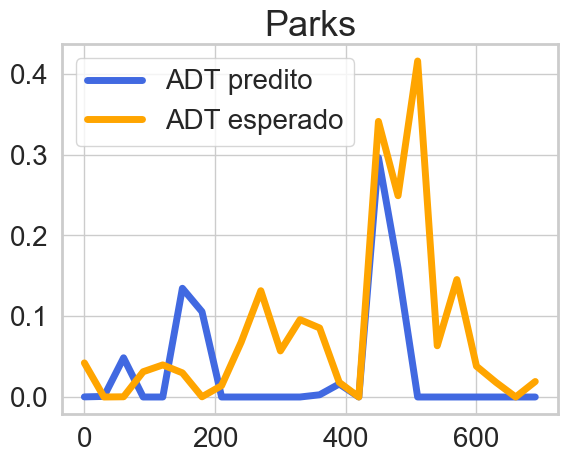

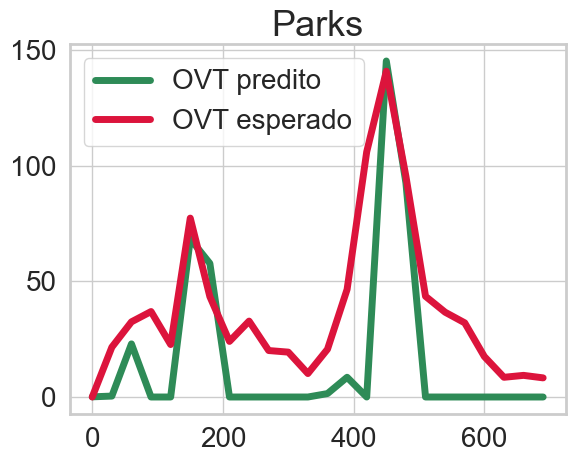

In [79]:
plt.title("Parks")
plt.plot(days, func(resultAll.params)[24:], label="ADT predito", color="royalblue")
plt.plot(days, park[24:], label="ADT esperado", color="orange")
plt.legend()
plt.show()

plt.title("Parks")
plt.plot(days, func(resultAll.params)[:24], label="OVT predito", color="seagreen")
plt.plot(days, park[:24], label="OVT esperado", color="crimson")
plt.legend()
predictedParks = func(resultAll.params)

In [80]:
# import seaborn as sns

# fig, axes = plt.subplots(nrows=int(np.ceil(len(sensible)/3)), ncols=3, figsize=(25, 10))
# axes = axes.flatten()
# n_runs = 1

# for ax, i in zip(axes, sensible):
#     print('Working with', i)
#     oldValue = params[i].value
#     params[i].vary = False
#     values = np.linspace(params[i].min, params[i].max, 60)
#     chisquares_mean = []
#     chisquares_std = []
#     for val in values:
#         print(i, '=', val)
#         params[i].value = val
#         chisq_runs = []
#         for _ in range(n_runs):
#             # Global optimization (differential_evolution)
#             result_global = lmfit.minimize(errorPark, params, method="differential_evolution")
#             # Local optimization (leastsq) using the result from global optimization
#             result = lmfit.minimize(errorPark, result_global.params, method="leastsq")
#             chisq_runs.append(result.chisqr)
#         chisquares_mean.append(np.min(chisq_runs))
#         chisquares_std.append(np.std(chisq_runs))
#     params[i].vary = True
#     params[i].value = oldValue
#     chisquares_mean = np.array(chisquares_mean)
#     chisquares_std = np.array(chisquares_std)
#     sns.lineplot(x=values, y=chisquares_mean, ax=ax, marker="o", color="royalblue", label="Min chi-squared")
#     #ax.fill_between(values, chisquares_mean-chisquares_std, chisquares_mean+chisquares_std, color="royalblue", alpha=0.2, label="Std. dev.")
#     ax.axvline(resultAll.params[i].value, linestyle='dashed', color='crimson', label='Best fit')
#     ax.set_title(i)
#     ax.set_xlabel('Value')
#     ax.set_ylabel('chi-squared')
#     ax.legend()
#     sns.despine(ax=ax)

# for ax in axes[len(sensible):]:
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

In [81]:
print(resultAll.params)

Parameters([('Tminmu1', <Parameter 'Tminmu1', value=20.0 (fixed), bounds=[0:40]>), ('fraction_mu1', <Parameter 'fraction_mu1', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmaxmu1', <Parameter 'Tmaxmu1', value=30.0 +/- 0, bounds=[-inf:inf], expr='Tminmu1 + fraction_mu1 * (40 - Tminmu1)'>), ('Tmin2', <Parameter 'Tmin2', value=20.0 (fixed), bounds=[0:40]>), ('fraction_2', <Parameter 'fraction_2', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmax2', <Parameter 'Tmax2', value=30.0 +/- 0, bounds=[-inf:inf], expr='Tmin2 + fraction_2 * (40 - Tmin2)'>), ('Tmin3', <Parameter 'Tmin3', value=25.0 (fixed), bounds=[0:40]>), ('fraction_3', <Parameter 'fraction_3', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmax3', <Parameter 'Tmax3', value=32.5 +/- 0, bounds=[-inf:inf], expr='Tmin3 + fraction_3 * (40 - Tmin3)'>), ('Tmingamma', <Parameter 'Tmingamma', value=29.875204555538946 +/- 8.6, bounds=[0:40]>), ('fraction_gamma', <Parameter 'fraction_gamma', value=0.999999999986047 +/- 1.79e+04, bounds=[0.1:1.0]>), ('Tm

### Fitting Houses

In [82]:
best_result = None
best_chisqr = np.inf

for i in range(10):
    print(f"Run {i+1}/10")
    # Global optimization (differential_evolution)
    result_global = lmfit.minimize(
        errorHouse,
        params2,
        method="differential_evolution",
        maxiter=2000,
        popsize=30,
        seed=i,  # Use a different seed for each run
        polish=True,
        tol=1e-8,
    )

    # Local optimization (leastsq) using the result from global optimization
    resultAll = lmfit.minimize(
        errorHouse,
        result_global.params,
        method="leastsq"
    )

    print(f"Run {i+1} chi-squared: {resultAll.chisqr}")
    if resultAll.chisqr < best_chisqr:
        best_chisqr = resultAll.chisqr
        best_result = resultAll

print("Best fit report:")
print(lmfit.fit_report(best_result))
resultAll = best_result
houseResult = best_result

Run 1/10
Run 1 chi-squared: 48.613089176782275
Run 2/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 2 chi-squared: 34.18644497879872
Run 3/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 3 chi-squared: 65.36205540592834
Run 4/10
Run 4 chi-squared: 43.76776315526661
Run 5/10
Run 5 chi-squared: 65.36205540592834
Run 6/10
Run 6 chi-squared: 34.18644479609084
Run 7/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 7 chi-squared: 398433265933786.8
Run 8/10
Run 8 chi-squared: 53.729770608568344
Run 9/10
Run 9 chi-squared: 36.31368939383968
Run 10/10
Run 10 chi-squared: 65.36205540592834
Best fit report:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 360
    # data points      = 48
    # variables        = 7
    chi-square         = 34.1864448
    reduced chi-square = 0.83381573
    Akaike info crit   = -2.28984623
    Bayesian info crit = 10.8085608
[[Variables]]
    Tminmu1:         20 (fixed)
    fraction_mu1:    0.5 (fixed)
    Tmaxmu1:         30.0000000 +/- 0.00000000 (0.00%) == 'Tminmu1 + fraction_mu1 * (40 - Tminmu1)'
    Tmin2:           20 (fixed)
    fraction_2:      0.5 (fixed)
    Tmax2:           30.0000000 +/- 0.00000000 (0.00%) == 'Tmin2 + fraction_2 * (40 - Tmin2)'
    Tmin3:           25 (fixed)
    fraction_3:      0.5 (fixed)
    Tmax3:           32.5000000 +/- 0.00000000 (0.00%) == 'Tmin3 + fraction_3 * (40 - Tmin3)'
    Tmingamma:       0.2334

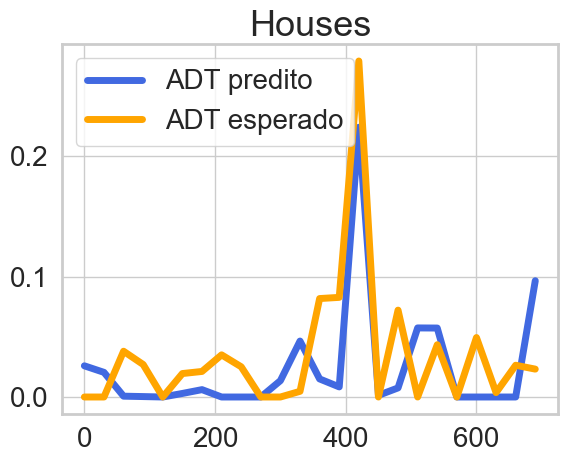

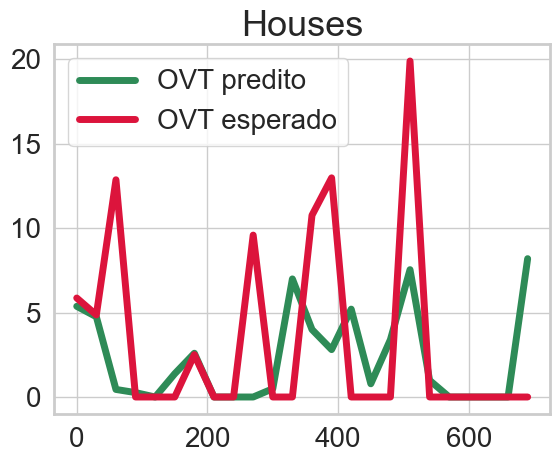

In [83]:
import matplotlib.pyplot as plt

plt.title("Houses")
plt.plot(days, func(resultAll.params)[24:], label="ADT predito", color="royalblue")
plt.plot(days, house[24:], label="ADT esperado", color="orange")
plt.legend()
plt.show()

plt.title("Houses")
plt.plot(days, func(resultAll.params)[:24], label="OVT predito", color="seagreen")
plt.plot(days, house[:24], label="OVT esperado", color="crimson")
plt.legend()
predictedHouses = func(resultAll.params)

In [84]:
# import seaborn as sns

# fig, axes = plt.subplots(nrows=int(np.ceil(len(sensible)/3)), ncols=3, figsize=(25, 8))
# axes = axes.flatten()
# for ax, i in zip(axes, sensible):
#     print('Working with', i)
#     oldValue = params[i].value
#     params[i].vary = False
#     values = np.linspace(params[i].min, params[i].max, 60)
#     chisquares = []
#     for val in values:
#         print(i, '=', val)
#         params[i].value = val
#         result = lmfit.minimize(errorHouse, params, method="differential_evolution")
#         chisquares.append(np.log(result.chisqr))
#     params[i].vary = True
#     params[i].value = oldValue
#     sns.lineplot(x=values, y=chisquares, ax=ax, marker="o", color="royalblue")
#     ax.axvline(resultAll.params[i].value, linestyle='dashed', color='crimson', label='Best fit')
#     ax.set_title(i)
#     ax.set_xlabel('Value')
#     ax.set_ylabel('log(chi-squared)')
#     ax.legend()
#     sns.despine(ax=ax)

# for ax in axes[len(sensible):]:
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

In [85]:
print(resultAll.params)

Parameters([('Tminmu1', <Parameter 'Tminmu1', value=20.0 (fixed), bounds=[0:40]>), ('fraction_mu1', <Parameter 'fraction_mu1', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmaxmu1', <Parameter 'Tmaxmu1', value=30.0 +/- 0, bounds=[-inf:inf], expr='Tminmu1 + fraction_mu1 * (40 - Tminmu1)'>), ('Tmin2', <Parameter 'Tmin2', value=20.0 (fixed), bounds=[0:40]>), ('fraction_2', <Parameter 'fraction_2', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmax2', <Parameter 'Tmax2', value=30.0 +/- 0, bounds=[-inf:inf], expr='Tmin2 + fraction_2 * (40 - Tmin2)'>), ('Tmin3', <Parameter 'Tmin3', value=25.0 (fixed), bounds=[0:40]>), ('fraction_3', <Parameter 'fraction_3', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmax3', <Parameter 'Tmax3', value=32.5 +/- 0, bounds=[-inf:inf], expr='Tmin3 + fraction_3 * (40 - Tmin3)'>), ('Tmingamma', <Parameter 'Tmingamma', value=0.23341689603775473 +/- 1.18e+03, bounds=[0:40]>), ('fraction_gamma', <Parameter 'fraction_gamma', value=0.9999999980282065 +/- 19.7, bounds=[0.1:1.0]>), (

### Fitting Streets

In [86]:
best_result = None
best_chisqr = np.inf

for i in range(10):
    print(f"Run {i+1}/10")
    # Global optimization (differential_evolution)
    result_global = lmfit.minimize(
        errorStreet,
        params2,
        method="differential_evolution",
        maxiter=2000,
        popsize=30,
        seed=i,  # Use a different seed for each run
        polish=True,
        tol=1e-8,
    )

    # Local optimization (leastsq) using the result from global optimization
    resultAll = lmfit.minimize(
        errorStreet,
        result_global.params,
        method="leastsq"
    )

    print(f"Run {i+1} chi-squared: {resultAll.chisqr}")
    if resultAll.chisqr < best_chisqr:
        best_chisqr = resultAll.chisqr
        best_result = resultAll

print("Best fit report:")
print(lmfit.fit_report(best_result))
resultAll = best_result
streetResult = best_result

Run 1/10
Run 1 chi-squared: 68.20994386599835
Run 2/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 2 chi-squared: 70.09225648068934
Run 3/10
Run 3 chi-squared: 108.35871652349718
Run 4/10
Run 4 chi-squared: 59.93105824096718
Run 5/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 5 chi-squared: 108.35871652349718
Run 6/10
Run 6 chi-squared: 61.68762438039016
Run 7/10


/Users/pedrolugao/Documents/finalPNAS/.venv/lib/python3.12/site-packages/lmfit/minimizer.py:447: RuntimeWarning: ignoring `maxiter` argument to `Minimizer()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, 'Minimizer'),


Run 7 chi-squared: 67.07428529419067
Run 8/10
Run 8 chi-squared: 67.01882150258028
Run 9/10
Run 9 chi-squared: 108.35871652349718
Run 10/10
Run 10 chi-squared: 108.35871652349718
Best fit report:
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 599
    # data points      = 48
    # variables        = 7
    chi-square         = 59.9310582
    reduced chi-square = 1.46173313
    Akaike info crit   = 24.6557053
    Bayesian info crit = 37.7541124
[[Variables]]
    Tminmu1:         20 (fixed)
    fraction_mu1:    0.5 (fixed)
    Tmaxmu1:         30.0000000 +/- 0.00000000 (0.00%) == 'Tminmu1 + fraction_mu1 * (40 - Tminmu1)'
    Tmin2:           20 (fixed)
    fraction_2:      0.5 (fixed)
    Tmax2:           30.0000000 +/- 0.00000000 (0.00%) == 'Tmin2 + fraction_2 * (40 - Tmin2)'
    Tmin3:           25 (fixed)
    fraction_3:      0.5 (fixed)
    Tmax3:           32.5000000 +/- 0.00000000 (0.00%) == 'Tmin3 + fraction_3 * (40 - Tmin3)'
    Tmingamma:       20.053

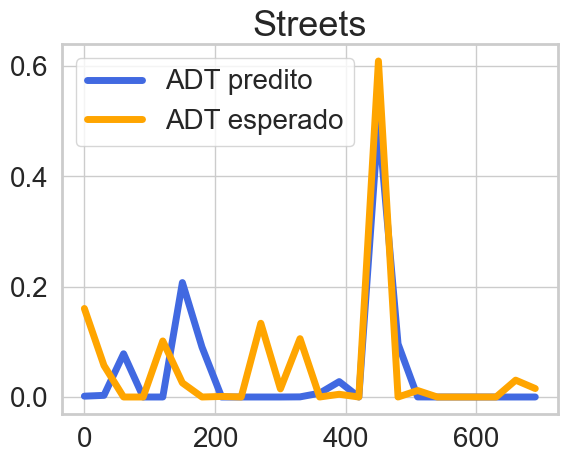

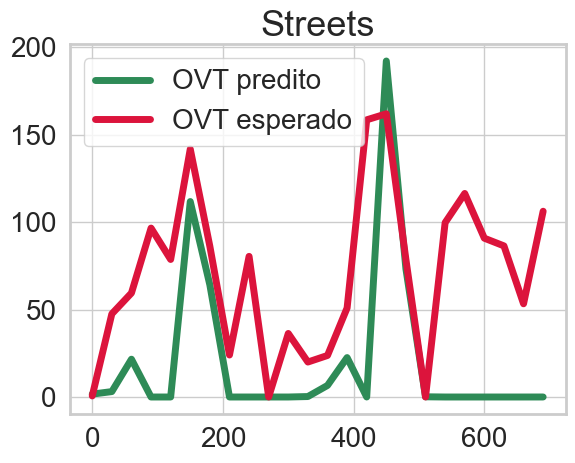

In [87]:
import matplotlib.pyplot as plt

plt.title("Streets")
plt.plot(days, func(resultAll.params)[24:], label="ADT predito", color="royalblue")
plt.plot(days, street[24:], label="ADT esperado", color="orange")
plt.legend()
plt.show()

plt.title("Streets")
plt.plot(days, func(resultAll.params)[:24], label="OVT predito", color="seagreen")
plt.plot(days, street[:24], label="OVT esperado", color="crimson")
plt.legend()
predictedStreets = func(resultAll.params)

In [89]:
resultAll.params

name,value,standard error,relative error,initial value,min,max,vary,expression
Tminmu1,20.0000000,0.00000000,(0.00%),20.0,0.00000000,40.0000000,False,
fraction_mu1,0.50000000,0.00000000,(0.00%),0.5,0.10000000,1.00000000,False,
Tmaxmu1,30.0000000,0.00000000,(0.00%),30.0,-inf,inf,False,Tminmu1 + fraction_mu1 * (40 - Tminmu1)
Tmin2,20.0000000,0.00000000,(0.00%),20.0,0.00000000,40.0000000,False,
fraction_2,0.50000000,0.00000000,(0.00%),0.5,0.10000000,1.00000000,False,
Tmax2,30.0000000,0.00000000,(0.00%),30.0,-inf,inf,False,Tmin2 + fraction_2 * (40 - Tmin2)
Tmin3,25.0000000,0.00000000,(0.00%),25.0,0.00000000,40.0000000,False,
fraction_3,0.50000000,0.00000000,(0.00%),0.5,0.10000000,1.00000000,False,
Tmax3,32.5000000,0.00000000,(0.00%),32.5,-inf,inf,False,Tmin3 + fraction_3 * (40 - Tmin3)
Tmingamma,20.0539790,8129.67012,(40538.94%),2.21626996768044,0.00000000,40.0000000,True,


In [90]:
print(resultAll.params)

Parameters([('Tminmu1', <Parameter 'Tminmu1', value=20.0 (fixed), bounds=[0:40]>), ('fraction_mu1', <Parameter 'fraction_mu1', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmaxmu1', <Parameter 'Tmaxmu1', value=30.0 +/- 0, bounds=[-inf:inf], expr='Tminmu1 + fraction_mu1 * (40 - Tminmu1)'>), ('Tmin2', <Parameter 'Tmin2', value=20.0 (fixed), bounds=[0:40]>), ('fraction_2', <Parameter 'fraction_2', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmax2', <Parameter 'Tmax2', value=30.0 +/- 0, bounds=[-inf:inf], expr='Tmin2 + fraction_2 * (40 - Tmin2)'>), ('Tmin3', <Parameter 'Tmin3', value=25.0 (fixed), bounds=[0:40]>), ('fraction_3', <Parameter 'fraction_3', value=0.5 (fixed), bounds=[0.1:1.0]>), ('Tmax3', <Parameter 'Tmax3', value=32.5 +/- 0, bounds=[-inf:inf], expr='Tmin3 + fraction_3 * (40 - Tmin3)'>), ('Tmingamma', <Parameter 'Tmingamma', value=20.053979021480473 +/- 8.13e+03, bounds=[0:40]>), ('fraction_gamma', <Parameter 'fraction_gamma', value=0.9999999999861465 +/- 9.08e+04, bounds=[0.1:1.0]>)

In [91]:
import json

def params_to_dict(params):
    """
    Converte parâmetros LMFit para dicionário.
    Os parâmetros agora usam o novo sistema com TMIN=0, TMAX=40 e frações.
    Para cada parâmetro:
    - Tmin_x: valor mínimo da temperatura para o parâmetro x
    - Tmax_x: valor máximo da temperatura para o parâmetro x
    - fraction_x: fração utilizada para calcular Tmax_x
    """
    result = {}
    for name, param in params.items():
        if hasattr(param, 'value'):
            result[name] = float(param.value)
    return result

with open('results_new_params.json', 'w') as f:
    json.dump({
        'park': params_to_dict(parkResult.params),
        'house': params_to_dict(houseResult.params),
        'street': params_to_dict(streetResult.params),
        'description': 'Results using new parametrization with TMIN=0, TMAX=40 and fractions'
    }, f, indent=2)

In [92]:
sensible

['Tmingamma',
 'fraction_gamma',
 'Tminr',
 'fraction_r',
 'Tmink',
 'fraction_k',
 'Tminee']

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\g'
/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_63135/3403127168.py:17: SyntaxWarning: invalid escape sequence '\m'
  tmin_names = ['$\mu_1$', '$\mu_2$', '$\mu_3$', '$\gamma$', '$r$', '$k$', '$e$']
/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_63135/3403127168.py:17: SyntaxWarning: invalid escape sequence '\m'
  tmin_names = ['$\mu_1$', '$\mu_2$', '$\mu_3$', '$\gamma$', '$r$', '$k$', '$e$']
/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_63135/3403127168.py:17: SyntaxWarning: invalid escape sequence '\m'
  tmin_names = ['$\mu_1$', '$\mu_2$', '$\mu_3$'

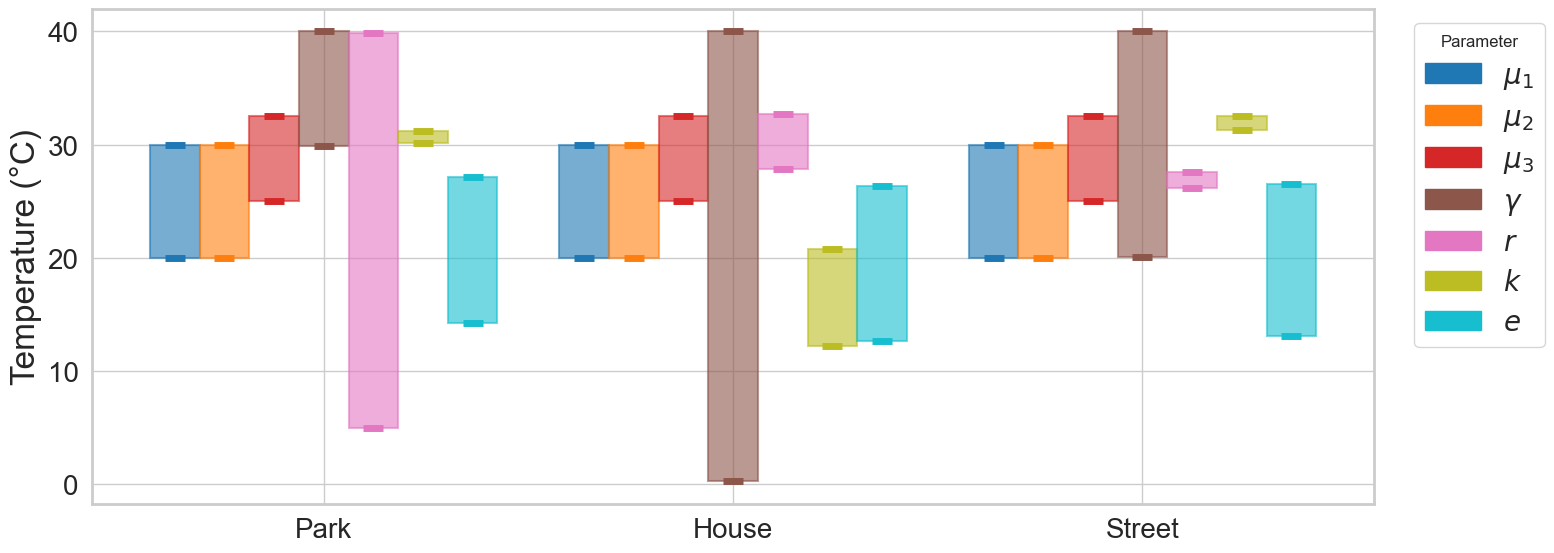

In [93]:
import numpy as np
import matplotlib.pyplot as plt
tmin_names = ['mu1', '2', '3', 'gamma', 'r', 'k', 'ee']
regions = ['park', 'house', 'street']
tmin_values_by_region = [
    [parkResult.params[f"Tmin{p}"].value for p in tmin_names],
    [houseResult.params[f"Tmin{p}"].value for p in tmin_names],
    [streetResult.params[f"Tmin{p}"].value for p in tmin_names],
]
tmin_names = ['mu1', '2', '3', 'gamma', 'r', 'k', 'e']
tmax_values_by_region = [
    [parkResult.params[f"Tmax{p}"].value for p in tmin_names],
    [houseResult.params[f"Tmax{p}"].value for p in tmin_names   ],
    [streetResult.params[f"Tmax{p}"].value for p in tmin_names],
]
# Prepare data
tmin_names = ['$\mu_1$', '$\mu_2$', '$\mu_3$', '$\gamma$', '$r$', '$k$', '$e$']
regions_cap = [r.capitalize() for r in regions]
n_regions = len(regions)
n_params = len(tmin_names)

# Colors for each parameter (consistent across regions)
param_colors = plt.cm.tab10(np.linspace(0, 1, n_params))

# Prepare bar positions
bar_width = 0.12
group_width = n_params * bar_width + 0.15  # space between regions
x = np.arange(n_regions) * group_width

fig, ax = plt.subplots(figsize=(16, 6))

for p_idx, param in enumerate(tmin_names):
    # For each region, get the Tmin and Tmax for this parameter
    tmin_vals = [tmin_values_by_region[r_idx][p_idx] for r_idx in range(n_regions)]
    tmax_vals = [tmax_values_by_region[r_idx][p_idx] for r_idx in range(n_regions)]
    # Offset for each parameter within the region group
    offset = (p_idx - n_params/2) * bar_width + bar_width/2
    # Plot Tmin
    # Plot interval as a box (rectangle) from Tmin to Tmax for each region/parameter
    for r_idx in range(n_regions):
        # Rectangle: left=x[r_idx]+offset-bar_width/2, width=bar_width, bottom=tmin_vals[r_idx], height=tmax_vals[r_idx]-tmin_vals[r_idx]
        rect = plt.Rectangle(
            (x[r_idx] + offset - bar_width/2, tmin_vals[r_idx]),
            bar_width,
            tmax_vals[r_idx] - tmin_vals[r_idx],
            color=param_colors[p_idx],
            alpha=0.6,
            label=param if r_idx == 0 else None,
            linewidth=1.5,
            edgecolor='black'
        )
        ax.add_patch(rect)
        
    # Optionally, plot a horizontal line at Tmin and Tmax for visual clarity
    ax.scatter(x + offset, tmin_vals, color=param_colors[p_idx], marker='_', s=200, zorder=3)
    ax.scatter(x + offset, tmax_vals, color=param_colors[p_idx], marker='_', s=200, zorder=3)

# X-tick labels as region names
ax.set_xticks(x)
ax.set_xticklabels(regions_cap)
ax.set_ylabel("Temperature (°C)")
#ax.set_title("Tmin and Tmax parameters by region (grouped by region, colored by parameter)")
# Custom legend for parameters
handles = []
for p_idx, param in enumerate(tmin_names):
    handles.append(plt.Rectangle((0,0),1,1, color=param_colors[p_idx], label=param))
ax.legend(handles, tmin_names, title="Parameter", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Joining everything

In [94]:
matProporcoes = np.array([[ 0.21198526, 0.10366928, 0.68434546],
        [0.56449287, 0.06473322, 0.37077391],
        [0.00688992, 0.23730171, 0.75580836]])

In [95]:
ADT_parque = predictedParks[24:]
ADT_rua = predictedStreets[24:]
ADT_casa = predictedHouses[24:]

OVT_parque = predictedParks[:24]
OVT_rua = predictedStreets[:24]
OVT_casa = predictedHouses[:24]

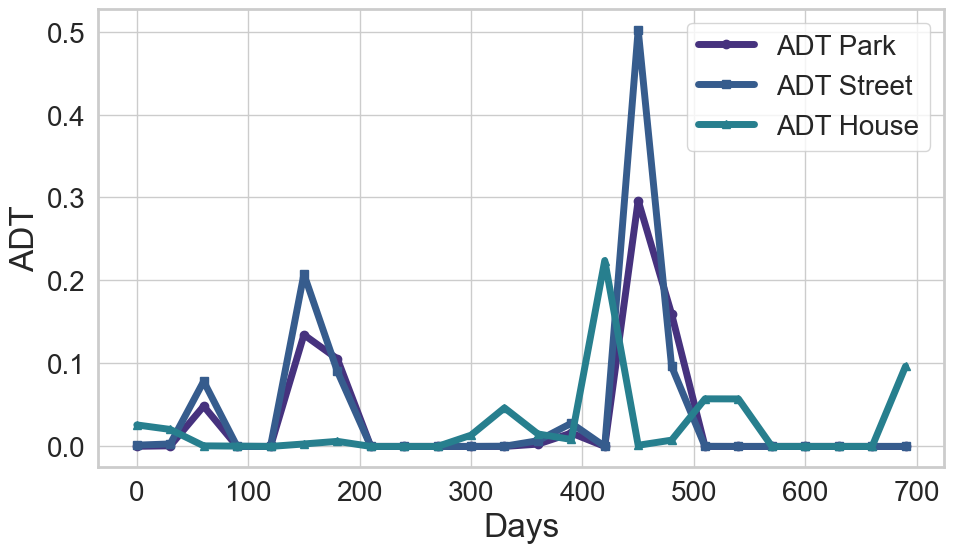

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(days, ADT_parque, label='ADT Park', marker='o')
plt.plot(days, ADT_rua, label='ADT Street', marker='s')
plt.plot(days, ADT_casa, label='ADT House', marker='^')
plt.xlabel('Days')
plt.ylabel('ADT')
#plt.title('ADT for Park, Street, and House')
plt.legend()
plt.tight_layout()
plt.show()

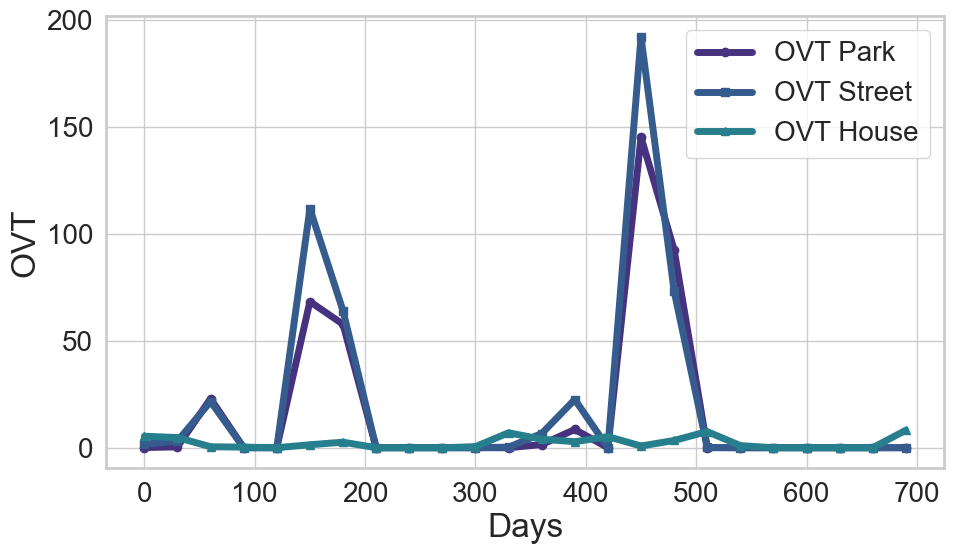

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(days, OVT_parque, label='OVT Park', marker='o')
plt.plot(days, OVT_rua, label='OVT Street', marker='s')
plt.plot(days, OVT_casa, label='OVT House', marker='^')
plt.xlabel('Days')
plt.ylabel('OVT')
#plt.title('OVT for Park, Street, and House')
plt.legend()
plt.tight_layout()
plt.show()

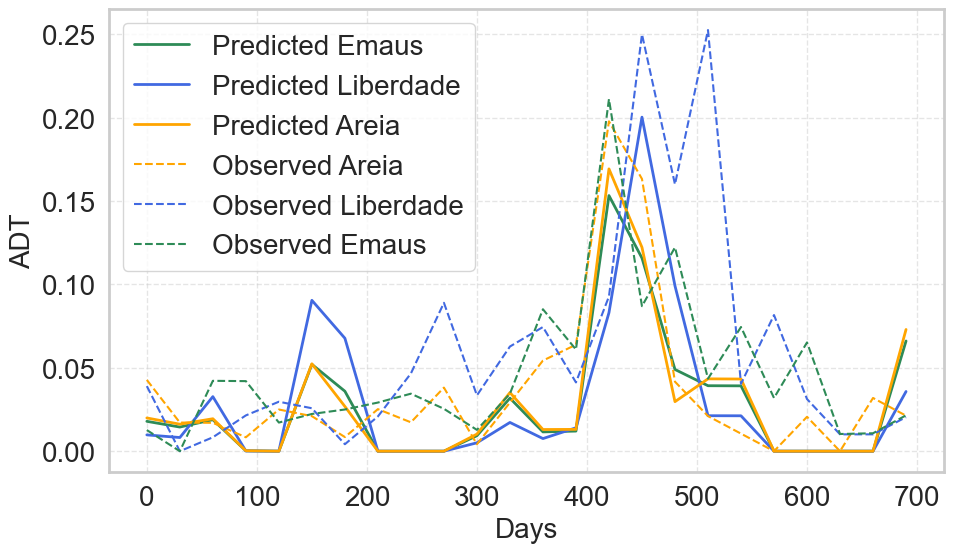

In [110]:
emausADTR = np.zeros(24)
liberdadeADTR = np.zeros(24)
areiaADTR =np.zeros(24)
for t in range(24):
    R = matProporcoes@[ADT_parque[t],ADT_rua[t],ADT_casa[t]]
    emausADTR[t],liberdadeADTR[t],areiaADTR[t] = R[0] , R[1], R[2]
plt.figure(figsize=(10, 6))
plt.plot(days, emausADTR, label='Predicted Emaus', color='seagreen', linewidth=2)
plt.plot(days, liberdadeADTR, label='Predicted Liberdade',  color='royalblue', linewidth=2)
plt.plot(days, areiaADTR, label='Predicted Areia',color='orange', linewidth=2)
plt.xlabel('Days', fontsize=20)
plt.ylabel('ADT', fontsize=20)

emausADT = [0.0126582278,0,0.0421940928,0.0420168067,0.017167382,0.0223214286,0.025,0.0291666667,0.0344827586,0.0254237288,0.0127659574,0.0344827586,0.085106383,0.0609756098,0.2111111111,0.0869565217,0.1222222222,0.0434782609,0.0744680851,0.0319148936,0.0652173913,0.0103092784,0.0107526882,0.0215053763]
liberdadeADT = [0.0390243902,0,0.0083333333,0.0214592275,0.0296610169,0.025751073,0.0041841004,0.0208333333,0.0466101695,0.0889830508,0.0334728033,0.0627615063,0.0744680851,0.0412371134,0.0927835052,0.25,0.16,0.2525252525,0.0404040404,0.0816326531,0.03125,0.0101010101,0.0101010101,0.0204081633]
areiaADT = [0.0427350427,0.017167382,0.0170212766,0.0083333333,0.025,0.0210084034,0.0084745763,0.025210084,0.0173160173,0.0381355932,0.0041666667,0.0291666667,0.0543478261,0.0638297872,0.1978021978,0.1632653061,0.0416666667,0.0210526316,0.0105263158,0,0.0206185567,0,0.0319148936,0.0212765957]
plt.plot(days,areiaADT, '--',label='Observed Areia', color='orange',linewidth=1.5)
plt.plot(days,liberdadeADT,'--',label='Observed Liberdade',color='royalblue',linewidth=1.5)
plt.plot(days,emausADT,'--',label='Observed Emaus', color='seagreen',linewidth=1.5)


#plt.title('Predicted ADT for Emaus, Liberdade, and Areia', fontsize=16)
plt.legend(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

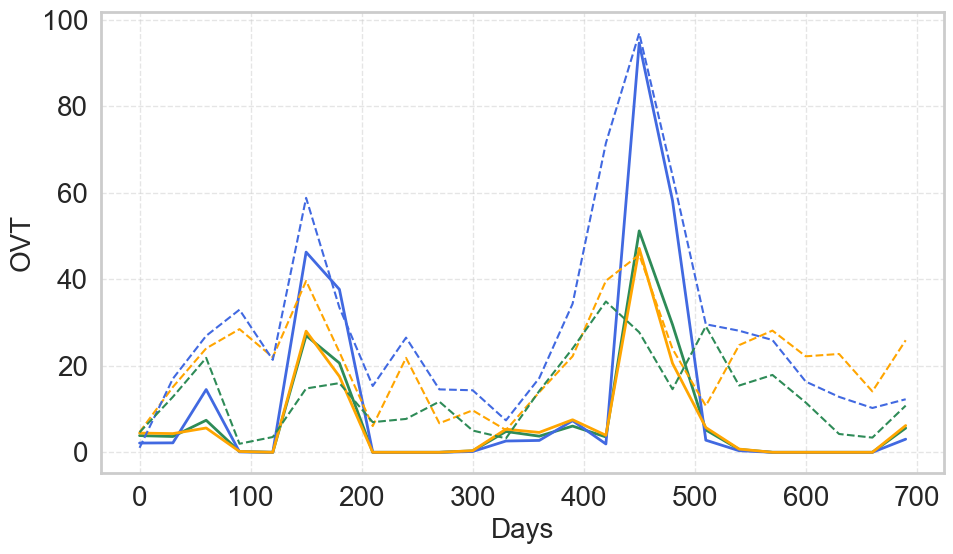

In [107]:
emausOR = np.zeros(24)
liberdadeOR = np.zeros(24)
areiaOR =np.zeros(24)
for t in range(24):
    R = matProporcoes@[OVT_parque[t],OVT_rua[t],OVT_casa[t]]
    emausOR[t],liberdadeOR[t],areiaOR[t] = R[0] , R[1], R[2]
plt.figure(figsize=(10, 6))
plt.plot(days, emausOR, label='Predicted Emaus', color='seagreen', linewidth=2)
plt.plot(days, liberdadeOR, label='Predicted Liberdade', color='royalblue', linewidth=2)
plt.plot(days, areiaOR, label='Predicted Areia', color='orange', linewidth=2)

emausOVT = [4.6173913043,12.811965812,21.8403361345,1.974789916,3.5333333333,14.7610619469,16,6.974137931,7.7179487179,11.7203389831,5.0344827586,3.2268907563,14.1964285714,24.0090909091,34.8813559322,27.7692307692,14.5982905983,29.1391304348,15.4406779661,17.8907563025,11.5084745763,4.2352941176,3.4,10.7943925234]
liberdadeOVT = [1.038961039,17.025,26.9401709402,32.9829059829,21.3833333333,58.8559322034,33.4705882353,15.3389830508,26.5210084034,14.55,14.35,7.3865546218,17.1764705882,34.3529411765,71.5338983051,96.9327731092,64.0084033613,29.6134453782,28.1186440678,25.9743589744,16.3474576271,12.8220338983,10.25,12.268907563]
areiaOVT = [4.6548672566,15.0956521739,24.0423728814,28.4871794872,21.9739130435,39.6379310345,23.1764705882,6.0672268908,21.8389830508,6.7192982456,9.7043478261,5.1465517241,13.9043478261,22.2,39.6666666667,45.7090909091,23.9203539823,10.7477477477,24.7913043478,28.1495327103,22.201754386,22.7456140351,14.0841121495,25.9137931034]
plt.plot(days,areiaOVT, '--',label='Observed Areia', color='orange',linewidth=1.5)
plt.plot(days,liberdadeOVT,'--',label='Observed Liberdade',color='royalblue',linewidth=1.5)
plt.plot(days,emausOVT,'--',label='Observed Emaus', color='seagreen',linewidth=1.5)

plt.xlabel('Days', fontsize=20)
plt.ylabel('OVT', fontsize=20)
#plt.title('Predicted OVT for Emaus, Liberdade, and Areia', fontsize=16)
#plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

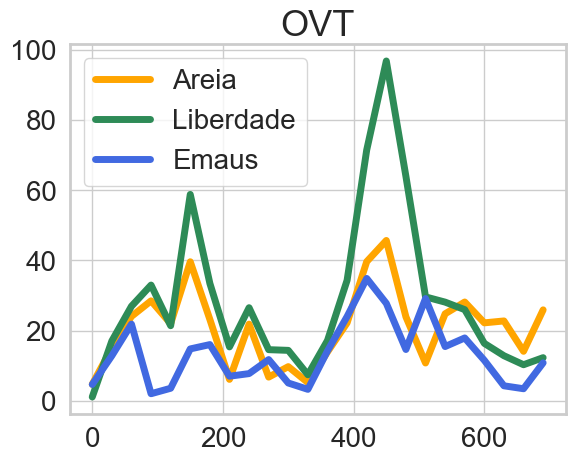

In [100]:
days = [0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510,540,570,600,630,660,690]
emausOVT = [4.6173913043,12.811965812,21.8403361345,1.974789916,3.5333333333,14.7610619469,16,6.974137931,7.7179487179,11.7203389831,5.0344827586,3.2268907563,14.1964285714,24.0090909091,34.8813559322,27.7692307692,14.5982905983,29.1391304348,15.4406779661,17.8907563025,11.5084745763,4.2352941176,3.4,10.7943925234]
liberdadeOVT = [1.038961039,17.025,26.9401709402,32.9829059829,21.3833333333,58.8559322034,33.4705882353,15.3389830508,26.5210084034,14.55,14.35,7.3865546218,17.1764705882,34.3529411765,71.5338983051,96.9327731092,64.0084033613,29.6134453782,28.1186440678,25.9743589744,16.3474576271,12.8220338983,10.25,12.268907563]
areiaOVT = [4.6548672566,15.0956521739,24.0423728814,28.4871794872,21.9739130435,39.6379310345,23.1764705882,6.0672268908,21.8389830508,6.7192982456,9.7043478261,5.1465517241,13.9043478261,22.2,39.6666666667,45.7090909091,23.9203539823,10.7477477477,24.7913043478,28.1495327103,22.201754386,22.7456140351,14.0841121495,25.9137931034]
plt.plot(days,areiaOVT,label='Areia', color='orange')
plt.plot(days,liberdadeOVT,label='Liberdade',color='seagreen')
plt.plot(days,emausOVT,label='Emaus', color='royalblue')
plt.title("OVT")
plt.legend()
plt.show()

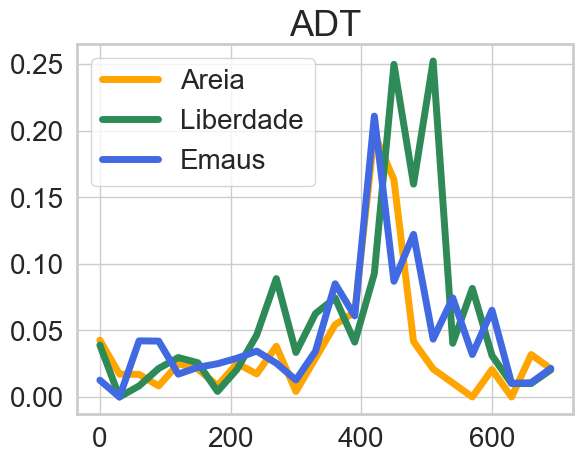

In [101]:
days = [0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510,540,570,600,630,660,690]
emausADT = [0.0126582278,0,0.0421940928,0.0420168067,0.017167382,0.0223214286,0.025,0.0291666667,0.0344827586,0.0254237288,0.0127659574,0.0344827586,0.085106383,0.0609756098,0.2111111111,0.0869565217,0.1222222222,0.0434782609,0.0744680851,0.0319148936,0.0652173913,0.0103092784,0.0107526882,0.0215053763]
liberdadeADT = [0.0390243902,0,0.0083333333,0.0214592275,0.0296610169,0.025751073,0.0041841004,0.0208333333,0.0466101695,0.0889830508,0.0334728033,0.0627615063,0.0744680851,0.0412371134,0.0927835052,0.25,0.16,0.2525252525,0.0404040404,0.0816326531,0.03125,0.0101010101,0.0101010101,0.0204081633]
areiaADT = [0.0427350427,0.017167382,0.0170212766,0.0083333333,0.025,0.0210084034,0.0084745763,0.025210084,0.0173160173,0.0381355932,0.0041666667,0.0291666667,0.0543478261,0.0638297872,0.1978021978,0.1632653061,0.0416666667,0.0210526316,0.0105263158,0,0.0206185567,0,0.0319148936,0.0212765957]
plt.plot(days,areiaADT,label='Areia', color='orange')
plt.plot(days,liberdadeADT,label='Liberdade', color='seagreen')
plt.plot(days,emausADT,label='Emaus', color='royalblue')
plt.title("ADT")
plt.legend()
plt.show()

In [102]:
from scipy.stats import pearsonr
import numpy as np

# Convert lists to numpy arrays for correlation calculation

corr_areiaADT, _ = pearsonr(np.array(areiaADT), areiaADTR)
corr_emausADT, _ = pearsonr(np.array(emausADT), emausADTR)
corr_liberdadeADT, _ = pearsonr(np.array(liberdadeADT), liberdadeADTR)

print(f"Pearson correlation (areiaADT vs areiaADTR): {corr_areiaADT:.3f}")
print(f"Pearson correlation (emausADT vs emausADTR): {corr_emausADT:.3f}")
print(f"Pearson correlation (liberdadeADT vs liberdadeADTR): {corr_liberdadeADT:.3f}")


Pearson correlation (areiaADT vs areiaADTR): 0.831
Pearson correlation (emausADT vs emausADTR): 0.720
Pearson correlation (liberdadeADT vs liberdadeADTR): 0.571


In [103]:
corr_areiaOVT, _ = pearsonr(np.array(areiaOVT), areiaOR)
corr_emausOVT, _ = pearsonr(np.array(emausOVT), emausOR)
corr_liberdadeOVT, _ = pearsonr(np.array(liberdadeOVT), liberdadeOR)

print(f"Pearson correlation (areiaOVT vs areiaOR): {corr_areiaOVT:.3f}")
print(f"Pearson correlation (emausOVT vs emausOR): {corr_emausOVT:.3f}")
print(f"Pearson correlation (liberdadeOVT vs liberdadeOR): {corr_liberdadeOVT:.3f}")


Pearson correlation (areiaOVT vs areiaOR): 0.584
Pearson correlation (emausOVT vs emausOR): 0.410
Pearson correlation (liberdadeOVT vs liberdadeOR): 0.801
